In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from ..FindCorrespondPts import findCorrespondPts
from ..segmentation import robotSegment, ransacCurveFit
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm_notebook
from utils import imshow, imshow2, distCal

In [3]:
# Loading parameters
imgl_pts = np.load('../calibration/blob_loc_left.npy')
imgr_pts = np.load('../calibration/blob_loc_right.npy')
coeff_left = np.load('../calibration/calibration_coeff_left.npy').item()
kl = coeff_left['intr_mat']

coeff_right = np.load('../calibration/calibration_coeff_right.npy').item()
kr = coeff_right['intr_mat']

trian_param = np.load('../calibration/triangulate_coeff.npy').item()

F = trian_param['F']
# 2 possible solutions for Rotation and Translation
R1 = trian_param['R1']
R2 = trian_param['R2']
T1 = trian_param['T1']
T2 = trian_param['T2']

# 4 Possible projection matrix for right camera
PR1 = np.hstack((R1, T1))
PR2 = np.hstack((R1, T2))
PR3 = np.hstack((R2, T1))
PR4 = np.hstack((R2, T2))

# Initialize Left projection matrix
PL = trian_param['PL']

PR = PR4

# Calculate template points
PR_cal = np.matmul(kr, PR)
PL_cal = np.matmul(kl, PL)

In [4]:
endL = np.load('./data_F/ptsL800_end.npy').item()
endR = np.load('./data_F/ptsR800_end.npy').item()

## Index Selection (Optional)

In [ ]:
# Duplicated index
rerange1 = list(range(123, 134))
rerange2 = list(range(362, 390))
rerange3 = list(range(507, 524))
rerange4 = list(range(626, 643))
rerange5 = list(range(650, 657))
rerange6 = list(range(679, 742))

filt1 = rerange1 + rerange2 + rerange3 + rerange4 + rerange5 + rerange6

# Extremely wrong segmentation results
filt2 = [0,1,13,16,60,91,99,100,101,120,135,154,204,215,232,233,238,244,259,263,286,
         300,339,344,353,357,361,427,439,479,482,506,549,624,625,646,659,678,785,793]


filt = filt1 + filt2

eval_idx = []
for idx in range(0, 800):
    if idx not in filt:
        eval_idx.append(idx)

In [6]:
# Obtain results for evaluation
pts3D_eval = {}
eval_idx = np.load('./data_F/eval_idx.npy')

for idx in tqdm_notebook(eval_idx):
    imgL = cv2.imread('../../data/CTR_Robot/Camera2/cam2_' + str(idx) + '.png')
    imgR = cv2.imread('../../data/CTR_Robot/Camera1/cam1_' + str(idx) + '.png')

    bg1 = cv2.imread('../segmentation/bg_res/bg_1.png')
    bg2 = cv2.imread('../segmentation/bg_res/bg_2_' + str(idx//50) + '.png')

    segL = robotSegmentv2(imgL, bg2)
    segR = robotSegmentv2(imgR, bg1)
    
    pts_end_R = endR[idx][1]
    pts_end_L = endL[idx][1]
    
    ptsR = ransacCurveFit_v3(segR, pt_end = pts_end_R, degree = 7, trials = 100, sampleNum = 100000)
    ptsL = ransacCurveFit_v3(segL, pt_end = pts_end_L, degree = 7, trials = 100, sampleNum = 100)

    ptsL_cor, ptsR_cor = findCorrespondPts_v3(ptsL, ptsR, F, thresh = 0.01)

    pts = cv2.triangulatePoints(PL_cal, PR_cal, ptsL_cor, ptsR_cor).T
    pts3D = cv2.convertPointsFromHomogeneous(pts).T[:,0]
    pts3D_eval[idx] = [ptsL_cor, ptsR_cor, pts3D]

In [8]:
## Outer section
pt_seg_left = np.load('./data_F/ptsL800_out.npy').item()
pt_seg_right = np.load('./data_F/ptsR800_out.npy').item()

#eval_idx_dup = list(pt_seg_left.keys()) + list(pt_seg_right.keys())
#eval_idx = list(set(eval_idx_dup))
eval_idx = np.load('./data_F/eval_idx.npy')

pt_joint_eval = {}

for idx in tqdm_notebook(eval_idx):
    if idx in pt_seg_left:
        pt_seg = pt_seg_left
        pts_cor = pts3D_eval[idx][0]
    elif idx in pt_seg_right:
        pt_seg = pt_seg_right
        pts_cor = pts3D_eval[idx][1]

    # extract label joint points 
    pt1 = pt_seg[idx]

    # calculate most close points as joint point
    mat1 = pts_cor[0] - pt1
    dist1 = np.sqrt(np.diag(np.matmul(mat1, mat1.T)))
    jointPt1 = np.argmin(dist1)

    # save 2 joints for each case
    pt_joint_eval[idx] = jointPt1

In [9]:
def distCal(pts):
    L = 0
    Xs, Ys, Zs = pts[0], pts[1], pts[2]
    for idx in range(len(pts)-1):
        xd = (Xs[idx-1]-Xs[idx])**2
        yd = (Ys[idx-1]-Ys[idx])**2
        zd = (Zs[idx-1]-Zs[idx])**2
        L += np.sqrt(xd+yd+zd)
    return L

In [10]:
imgl_pts = np.load('../calibration/blob_loc_left.npy')
imgr_pts = np.load('../calibration/blob_loc_right.npy')
temp = cv2.triangulatePoints(PL_cal, PR_cal, imgl_pts, imgr_pts).T
temp3D = cv2.convertPointsFromHomogeneous(temp).T[:,0]
# Recover scale from template points
Xs_tp = temp3D[0]
Ys_tp = temp3D[1]
Zs_tp = temp3D[2]

dist_dot = []
for idx in range(len(Xs_tp)-1):
    xd = (Xs_tp[idx]-Xs_tp[idx+1])**2
    yd = (Ys_tp[idx]-Ys_tp[idx+1])**2
    zd = (Zs_tp[idx]-Zs_tp[idx+1])**2
    L = np.sqrt(xd+yd+zd)
    if L < 0.1:
        dist_dot.append(L)
recon_dist = np.mean(dist_dot)

In [11]:
# Load length data
from scipy.io import loadmat
dist_gt = {}
for idx in pts3D_eval.keys():
    mat = loadmat('../../data/CTR_Robot/Robot_data/pos_' + str(idx) + '.mat')['pos'][0]
    # Calculate ground truth length
    dist_inner = 431 + mat[0]*1000
    #dist_mid = 332 + mat[1]*1000
    dist_out = 174 + mat[2]*1000
    # Save results
    dist_gt[idx] = (dist_inner, dist_out)

In [12]:
# Evaluate
dist_eval = {}
template_dist = 18.2
scale = template_dist/recon_dist
for idx in eval_idx:
    # Load reconstruction result
    pts3D = pts3D_eval[idx][2]
    # Load segment point idx
    seg_idx1 = pt_joint_eval[idx]
    # Outter seg
    seg1 = pts3D.T[0:seg_idx1]
    # Inner seg
    seg3 = pts3D.T
    
    dist_out = distCal(seg1.T)*scale
    dist_inner = distCal(seg3.T)*scale
    
    dist_eval[idx] = (dist_inner, dist_out) 
    
# Caculate Error
error = {}
for idx in eval_idx:
    gt_in, gt_out = dist_gt[idx]
    cal_in, cal_out = dist_eval[idx]
    error[idx] = (gt_in-cal_in, gt_out-cal_out)

In [ ]:
# Save Data
np.save('./results/pts3D_res.npy', pts3D_eval)
np.save('./results/dist_eval.npy', dist_eval)
np.save('./results/dist_gt.npy', dist_gt)
np.save('./results/dist_error.npy', error)

In [3]:
# Data analysis
pts3D_eval = np.load('./results/pts3D_res.npy').item()
dist_eval = np.load('./results/dist_eval.npy').item()
dist_gt = np.load('./results/dist_gt.npy').item()
error = np.load('./results/dist_error.npy').item()

out_cal = []
inner_cal = []

out_gt = []
inner_gt = []

out_error = []
inner_error = []

index = []

for key in dist_eval.keys():
    index.append(key)
    
    out_cal.append(dist_eval[key][1])
    inner_cal.append(dist_eval[key][0])
    
    out_gt.append(dist_gt[key][1])
    inner_gt.append(dist_gt[key][0])
    
    out_error.append(error[key][1])
    inner_error.append(error[key][0])

data = {
    'index': index,   
    'inner_cal': inner_cal,
    'out_cal': out_cal,  
    'inner_gt':inner_gt,  
    'out_gt': out_gt,
    'inner_error':inner_error,  
    'out_error':out_error,
}

In [4]:
res_data = pd.DataFrame(data)
res_data

,index,inner_cal,out_cal,inner_gt,out_gt,inner_error,out_error
0,2,166.283912,156.352571,160.613035,160.105442,-5.670876,3.752871
1,3,196.886405,135.677298,204.390367,137.421480,7.503963,1.744182
2,4,211.568804,128.445260,212.950037,128.178299,1.381233,-0.266961
3,6,187.756932,152.954111,170.327741,155.677336,-17.429191,2.723225
4,7,162.997713,146.610782,158.944937,150.935432,-4.052776,4.324650
5,8,173.088712,126.134119,177.644216,129.676695,4.555504,3.542576
6,9,160.054037,107.390189,160.287343,107.779113,0.233305,0.388924
7,10,150.681733,129.623793,148.808381,132.306574,-1.873352,2.682780
8,11,191.345917,139.434008,184.029945,140.020983,-7.315973,0.586975
9,12,212.165187,148.197562,222.198904,149.963258,10.033718,1.765697


In [8]:
res_data['inner_cal']
np.corrcoef(res_data['inner_cal'], res_data['inner_gt'])

array([[1.        , 0.96869724],
       [0.96869724, 1.        ]])

In [9]:
mean = np.mean(np.abs(res_data['inner_error']))
dev = np.std(np.abs(res_data['inner_error']))

print('Inner tube: Mean %f, deviation %f' % (mean, dev))

Inner tube: Mean 4.827041, deviation 3.935295


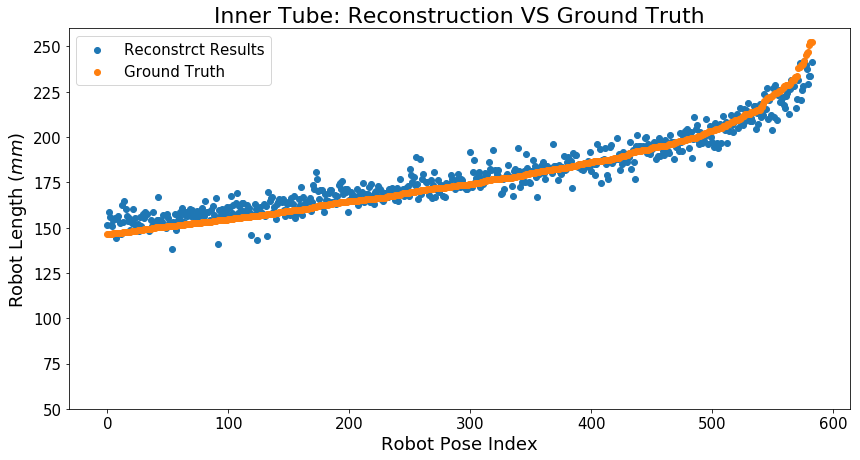

In [26]:
%matplotlib inline
x = range(0,len(res_data['inner_cal']))
sort_by_innerCal = res_data.sort_values(['inner_gt'])
plt.figure(figsize=(14, 7))
plt.scatter(x, sort_by_innerCal['inner_cal'], label = 'Reconstrct Results')
plt.scatter(x, sort_by_innerCal['inner_gt'], label = 'Ground Truth')
plt.rc('xtick', labelsize=15)  
plt.rc('ytick', labelsize=15) 
plt.ylabel('Robot Length ($mm$)', fontsize = 18)
plt.xlabel('Robot Pose Index', fontsize = 18)
plt.ylim([50, 260])
plt.legend(fontsize = 15)
plt.title('Inner Tube: Reconstruction VS Ground Truth', fontsize = 22)
plt.savefig("final_eval_inner.pdf", bbox_inches='tight')
plt.show()

In [24]:
np.corrcoef(res_data['out_cal'], res_data['out_gt'])

array([[1.        , 0.99715919],
       [0.99715919, 1.        ]])

In [15]:
mean = np.mean(np.abs(res_data['out_error']))
max_d = np.max(np.abs(res_data['out_error']))
min_d = np.min(np.abs(res_data['out_error']))
std = np.std(np.abs(res_data['out_error']))
print('Outter tube: Max: %f, Min %f, Mean %f, Variance %f' % (max_d, min_d, mean, std))

Outter tube: Max: 20.553315, Min 0.001238, Mean 3.229556, Variance 1.894277


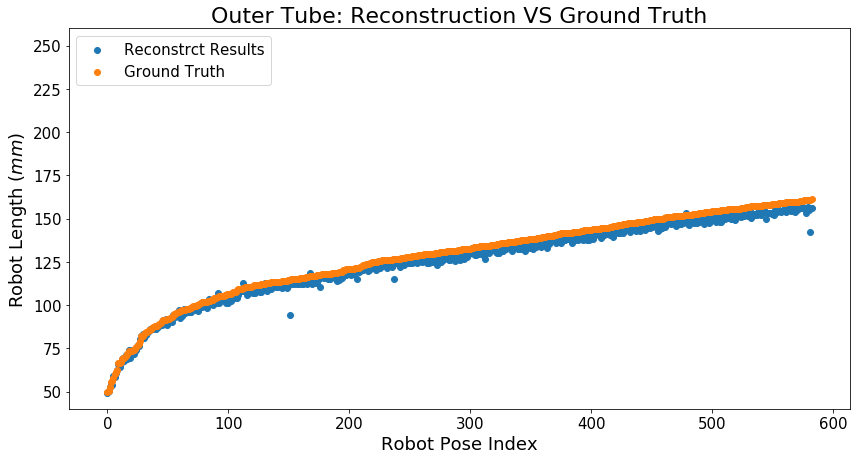

In [13]:
x = range(0,len(res_data['out_cal']))
sort_by_outCal = res_data.sort_values(['out_gt'])
plt.figure(figsize=(14, 7))
plt.scatter(x, sort_by_outCal['out_cal'], label = 'Reconstrct Results')
plt.scatter(x, sort_by_outCal['out_gt'], label = 'Ground Truth')
plt.rc('xtick', labelsize=15)  
plt.rc('ytick', labelsize=15) 
plt.ylabel('Robot Length ($mm$)', fontsize = 18)
plt.xlabel('Robot Pose Index', fontsize = 18)
plt.ylim([40, 260])
plt.legend(fontsize = 15, loc = 'upper left')
plt.title('Outer Tube: Reconstruction VS Ground Truth', fontsize = 22)
plt.savefig("final_eval_outer.pdf", bbox_inches='tight')
plt.show()

In [11]:
np.sum(np.abs(res_data['out_error']/res_data['out_gt']))/len(res_data['out_error'])

0.024558476756404955

In [12]:
np.sum(np.abs(res_data['inner_error']/res_data['inner_gt']))/len(res_data['inner_error'])

0.02753217011161283

In [12]:
np.median(np.abs(res_data['out_error']))

3.1853102939082447

In [13]:
np.median(np.abs(res_data['inner_error']))

3.847715993045

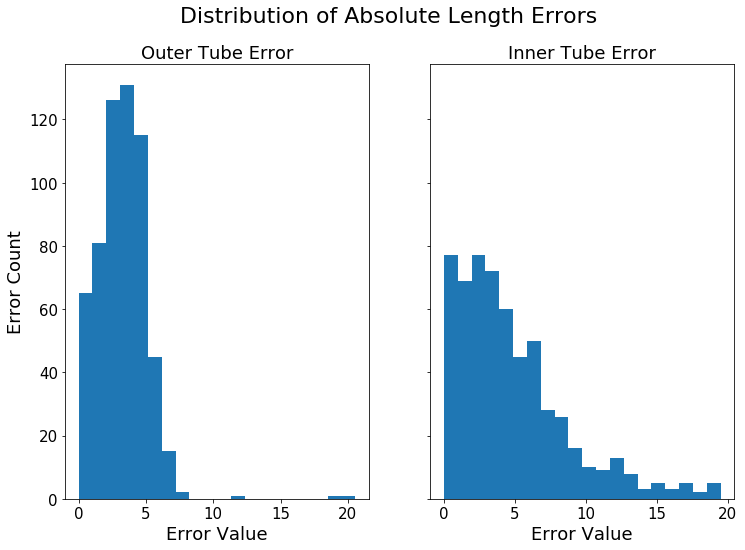

In [46]:
data1 = np.abs(res_data['inner_error'])
data2 = np.abs(res_data['out_error'])


fig, axs = plt.subplots(1, 2, sharey=True, figsize = (12, 8))
# We can set the number of bins with the `bins` kwarg
fig.suptitle('Distribution of Absolute Length Errors', fontsize=22)
axs[0].hist(data2, bins=20)
axs[1].hist(data1, bins=20)
axs[0].set_title('Outer Tube Error', fontsize = 18)
axs[1].set_title('Inner Tube Error', fontsize = 18)
axs[0].set_ylabel('Error Count', fontsize = 18)
axs[0].set_xlabel('Error Value', fontsize = 18)
axs[1].set_xlabel('Error Value', fontsize = 18)
plt.rc('xtick', labelsize=15)  
plt.rc('ytick', labelsize=15)
plt.show()

In [48]:
#fig.savefig("error_distribution.pdf", bbox_inches='tight')